In [1]:
# Загрузим необходимые библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt

## Обзор исходных данных

In [2]:
# Загрузим датасет
try:
    df_retail_dataset = pd.read_csv(r'C:\Users\User\OneDrive\Education\1_Ya_DA\18_final_project\retail_dataset.csv')
except:
    df_retail_dataset = pd.read_csv('...')
    

In [3]:
display(df_retail_dataset.head())

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [4]:
# Загрузим датасет с ценами
try:
    df_product_codes = pd.read_csv(r'C:\Users\User\OneDrive\Education\1_Ya_DA\18_final_project\product_codes.csv')
except:
    df_product_codes = pd.read_csv('...')  

In [5]:
display(df_product_codes.head())

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


## Предобработка данных

In [6]:
# Приведём названия столбцов датасетов к "змеиному" стилю
df_retail_dataset = (
    df_retail_dataset
        .rename(columns={
            'purchaseid': 'purchase_id'
            , 'item_ID': 'product_id'
            , 'Quantity': 'quantity'
            , 'purchasedate': 'purchase_date'
            , 'CustomerID': 'customer_id'
            , 'ShopID': 'shop_id'
        }
    )
)

df_product_codes = (
    df_product_codes
        .rename(columns={
            'productID': 'product_id'
            , 'price_per_one': 'product_price'
        }
    )
)

In [7]:
df_retail_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_id      105335 non-null  object 
 1   product_id       105335 non-null  object 
 2   quantity         105335 non-null  int64  
 3   purchase_date    105335 non-null  object 
 4   customer_id      69125 non-null   float64
 5   shop_id          105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


Видим пропущенные значения в колонке `customer_id`

In [8]:
df_product_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     9969 non-null   object 
 1   product_price  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


In [9]:
# Изменим типы данных
df_retail_dataset['purchase_date'] = df_retail_dataset['purchase_date'].astype('datetime64')
df_retail_dataset[['customer_id', 'loyalty_program']] = df_retail_dataset[['customer_id', 'loyalty_program']].apply(pd.to_numeric)

In [10]:
# Посмотрим процент пропущенных значений в колонке `customer_id`
#(df_retail_dataset['customer_id'].isna().sum() / df_retail_dataset['customer_id'].count() * 100).round(2)

In [11]:
(df_retail_dataset['customer_id'].isna().sum() / len(df_retail_dataset['customer_id']) * 100).round(2)

34.38

В датасете df_retail_dataset в столбце customer_id много пропущенных значений - 34.38 %. Мы не располагаем информацией об этих покупателях. Возможно, это клиенты, которые совершает покупку в магазинах сети в первый раз, а персональную карту получают после первой покупки. Так как у нас нет информации об этих покупателях, заменим пропущенные значения методом `fillna`.

In [12]:
df_retail_dataset['customer_id'] = df_retail_dataset['customer_id'].fillna(0)

In [13]:
# Посмотрим есть ли у нас дубликаты и сколько их
print(df_retail_dataset.duplicated().sum())
print('----')
print(df_product_codes.duplicated().sum())

1033
----
0


В df_retail_dataset - 1033 строк дубликатов, в df_product_codes - 0 дубликатов. Посмотрим, что это за строки.

In [14]:
# Выведем дубликаты с сортировкой по столбцам purchase_id и product_id
df_retail_dataset[df_retail_dataset.duplicated()].sort_values(by=['purchase_id', 'product_id'])

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
56087,536409,21866,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
54076,536409,22111,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
60212,536409,22866,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
40618,536409,22900,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
70869,536412,21448,1,2016-12-01 11:49:00,23599.0,Shop 0,1.0
...,...,...,...,...,...,...,...
49268,C544583,S,-2,2017-02-21 14:48:00,0.0,Shop 0,0.0
60901,C544583,S,-2,2017-02-21 14:48:00,0.0,Shop 0,0.0
79282,C544583,S,-2,2017-02-21 14:48:00,0.0,Shop 0,0.0
83635,C544583,S,-2,2017-02-21 14:48:00,0.0,Shop 0,0.0


Видим, что у нас есть нулевые количества купленного товара, выведем дубли без них. Отрицательные значения по колонке quantity пока не трогаем, так как мы не знаем чем это вызвано. Негативная статистика приходится на магазин `Shop 0`

In [15]:
# Выведем количество ненулевых дублей
(
    df_retail_dataset[df_retail_dataset.duplicated()]
        .query('quantity != 0')
        .sort_values(by=['purchase_id', 'product_id'])['purchase_id']
        .count()
)

340

In [16]:
# Выведем количество дублей по магазину `Shop 0`
(
        df_retail_dataset[df_retail_dataset.duplicated()]
        .query('shop_id == "Shop 0"')
        .sort_values(by=['purchase_id', 'product_id'])['purchase_id']
        .count()
)

1023

В датасете df_retail_dataset 1033 строк-дубликатов, что составляет меньше 1 %. Большинство дубликатов - это товары с нулевым количеством. Строк-дубликатов с ненулевым количеством купленного товара - 340. Почти все дубликаты приходятся на магазин "Shop 0".

Думаю, что в ретейле, встречаются задвоенные заказы, либо это ошибка кассового терминала, либо какая-то другая аномалия. В любом случае, природа этой ошибки нам не известна, поэтому удалим эти строки из наших данных. Тем не менее, было бы полезно разобраться в причинах этой аномалии.

In [17]:
# Удалим дубликаты
df_retail_dataset = df_retail_dataset.drop_duplicates().reset_index(drop=True)

In [18]:
# Посмотрим, что у нас с неявными дубликатами
df_retail_dataset.sort_values(by='shop_id')['shop_id'].nunique()

31

In [19]:
df_retail_dataset.sort_values(by='shop_id')['shop_id'].unique()

array(['Shop 0', 'Shop 1', 'Shop 10', 'Shop 11', 'Shop 12', 'Shop 13',
       'Shop 14', 'Shop 15', 'Shop 16', 'Shop 17', 'Shop 18', 'Shop 19',
       'Shop 2', 'Shop 20', 'Shop 21', 'Shop 22', 'Shop 23', 'Shop 24',
       'Shop 25', 'Shop 26', 'Shop 27', 'Shop 28', 'Shop 29', 'Shop 3',
       'Shop 30', 'Shop 4', 'Shop 5', 'Shop 6', 'Shop 7', 'Shop 8',
       'Shop 9'], dtype=object)

In [20]:
df_product_codes.sort_values(by='product_id')['product_id'].nunique()

3159

In [21]:
np.set_printoptions(threshold=4000)

df_product_codes.sort_values(by='product_id')['product_id'].unique()

array(['10002', '10080', '10120', '10123C', '10124A', '10124G', '10125',
       '10133', '10135', '11001', '15034', '15036', '15039', '15044A',
       '15044B', '15044C', '15044D', '15056BL', '15056N', '15056P',
       '15056bl', '15056n', '15056p', '15058A', '15058B', '15058C',
       '15060B', '16008', '16010', '16011', '16012', '16014', '16015',
       '16016', '16033', '16045', '16046', '16048', '16052', '16054',
       '16156L', '16156S', '16161M', '16161P', '16161U', '16162L',
       '16168M', '16169K', '16169M', '16169N', '16169P', '16202E',
       '16206B', '16207A', '16207B', '16216', '16218', '16219', '16225',
       '16235', '16236', '16237', '16238', '16258A', '17001', '17003',
       '17007B', '17011A', '17011F', '17012A', '17012B', '17012C',
       '17012D', '17012E', '17012F', '17013D', '17014A', '17021',
       '17028J', '17038', '17084A', '17084J', '17084N', '17084P',
       '17084R', '17090A', '17090D', '17091A', '17091J', '17096',
       '17107D', '17109D', '17129F',

In [22]:
# Проверим некоторые коды на аномалии
print(df_product_codes.query('product_id == "10002"'))
print('------------------------------')
print(df_product_codes.query('product_id == "10123C"'))
print('------------------------------')
print(df_product_codes.query('product_id == "20615"'))
print('------------------------------')
print(df_product_codes.query('product_id == "AMAZONFEE"'))
print('------------------------------')
print(df_product_codes.query('product_id == "BANK CHARGES"'))
print('------------------------------')
print(df_product_codes.query('product_id == "C2"'))
print('------------------------------')
print(df_product_codes.query('product_id == "DOT"'))
print('------------------------------')
print(df_product_codes.query('product_id == "POST"'))
print('------------------------------')
print(df_product_codes.query('product_id == "gift_0001_20"'))

     product_id  product_price
31        10002           0.85
2459      10002           1.66
8122      10002           1.63
------------------------------
     product_id  product_price
2431     10123C           0.65
------------------------------
     product_id  product_price
2349      20615           2.10
2461      20615           4.21
3881      20615           0.00
6056      20615           1.66
7599      20615           1.63
8026      20615           4.13
------------------------------
     product_id  product_price
3891  AMAZONFEE           1.00
3931  AMAZONFEE       13541.33
4089  AMAZONFEE       13474.79
4094  AMAZONFEE        5519.25
4095  AMAZONFEE        6706.71
6133  AMAZONFEE       16888.02
6134  AMAZONFEE       16453.71
9732  AMAZONFEE        5575.28
9733  AMAZONFEE        5258.77
------------------------------
        product_id  product_price
2199  BANK CHARGES          15.00
3884  BANK CHARGES          95.38
5041  BANK CHARGES         966.92
8168  BANK CHARGES        1

В датасете `df_product_code` присутствуют неявные дубли кодов продукта. Коды не имеют единой логики оформления, отличаются регистром букв и цифр кода. Возможно, разное оформление кодов у поставщика и сети магазинов. На некоторые дубли цена сильно отличается, допускаю, что каждое новое поступление товара размещали в информационной системе магазинов с новой ценой поставки. Так как у нас нет чёткого понимания природы данной аномалии, оставим эти коды как есть.

Что же касается таких кодов, как "AMAZONFEE", "BANK CHARGES", то у них большой разброс цен и судя по названию, эти коды не имеют отношения к товарам. Уберем строки с этими кодами из датасета, чтобы они не вводили нас в заблуждение.

Остальные коды из нашей проверки - "C2", "DOT"("Точка"), "POST"("Почта"), "gift_0001_20"("Подарок") возможно, имеют отношения к перемещениям в точки продаж, почтовым отправлениям, подарочным картам и так далее. Невозможно однозначно утверждать, что это именно так, поэтому оставим эти коды без изменения.

In [23]:
# Проверим колонку `quantity` на предмет аномальных количеств
df_retail_dataset.query('quantity < -1000 or quantity > 1000').sort_values(by='quantity', ascending=False)

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
68612,541431,23166,74214,2017-01-18 10:01:00,18025.0,Shop 0,0.0
31870,542504,37413,5567,2017-01-28 12:03:00,0.0,Shop 0,0.0
103712,544612,22053,3905,2017-02-22 10:43:00,23766.0,Shop 0,1.0
38442,540815,21108,3113,2017-01-11 12:55:00,21428.0,Shop 0,0.0
12710,536830,84077,2879,2016-12-02 17:38:00,22433.0,Shop 0,1.0
17365,543057,84077,2591,2017-02-03 10:50:00,22012.0,Shop 0,1.0
41382,542505,79063D,2559,2017-01-28 12:04:00,0.0,Shop 0,0.0
3229,539101,22693,2399,2016-12-16 10:35:00,21708.0,Shop 0,0.0
84133,544152,18007,2399,2017-02-16 12:10:00,20288.0,Shop 0,0.0
81812,543669,22693,2399,2017-02-11 11:22:00,21708.0,Shop 0,0.0


Видим два больших выброса по первой и последней строке, по модулю примерно одинаковых. Возможно, это какая-то "пересортица" плюс на минус при инвентаризации складских остатков или неправильная отгрузка/приход. Есть большое желание их удалить, но так как нам неизвеста причина расхождений, оставим так.

In [24]:
# Оформим новый датасет с учётом удаления строк с "AMAZONFEE" и "BANK CHARGES"
df_retail_dataset_new = (
    pd.DataFrame(
        df_retail_dataset
            .query('product_id != "AMAZONFEE" and product_id != "BANC CHARGES" and -1000 < quantity < 1000')
    )
)

In [25]:
# Посмотрим на цены датасета `df_product_codes` применим группировку 
# с выводом медианной цены
df_product_codes_groupby = (
    df_product_codes
        .groupby('product_id', as_index=False)
        .agg({'product_price': 'median'})
)

#df_product_codes_groupby.columns=['product_id', 'product_price']

В датасете `df_product_codes` разные цены почти на каждый код, при этом разброс цен в пределах кода достаточно большой, цены могут отличаться в два раза. Так как нет понимания, почему цены отличаются и в какой момент изменилась цена, то для дальнейшего анализа было принято решение взять за основу медианную цену по каждому коду. Так же, в датасете присутствуют товары с нулевой ценой и отрицательной ценой - возможно, это были неправильные перемещения, оприходования, инвентаризация, либо промо подарки.

Итак в предобработке данных мы сделали:
- изменили названия столбцов,
- изменили типы данных в столбцах "customer_id", "purchase_date", "loyaltu_program",
- пропуски в  столбце "customer_id" заменены на 0,
- удалили строки-дубликаты в датасета `df_retail_dataset`,
- удалили строки с кодами продукта "AMAZONFEE" и "BANK CHARGES",
- вычислили медианную цену в датасете `df_product_codes`.

## Исследовательский анализ данных

In [26]:
# Добавим столбцы с датой, неделей и месяцем покупки
df_retail_dataset_new['date'] = df_retail_dataset_new['purchase_date'].dt.date.astype('datetime64')
df_retail_dataset_new['week'] = df_retail_dataset_new['date'].dt.isocalendar().week
df_retail_dataset_new['month'] = df_retail_dataset_new['date'].dt.month


In [27]:
# Объединим датасеты
df = (
    df_retail_dataset_new
        .merge(
            df_product_codes_groupby
                , on='product_id'
                , how='left'
        )
)

In [28]:
# Добавим колонку с суммой покупки по каждой строке
df['revenue'] = df['quantity'] * df['product_price']

In [29]:
# Посмотрим каким периодом представлены данные 
print(df['date'].min())
print('-------------------')
print(df['date'].max())


2016-12-01 00:00:00
-------------------
2017-02-28 00:00:00


Итак, у нас данные с 1 декабря 2016 г. по 28 февраля 2017 г., то есть за три месяца.

In [30]:
# Выведем статистику по трём колонкам, остальные нам пока не интересны
df[['quantity', 'product_price', 'revenue']].describe().round()

,quantity,product_price,revenue
count,104252.0,104252.0,104252.0
mean,7.0,5.0,20.0
std,27.0,10.0,97.0
min,-991.0,0.0,-4277.0
25%,0.0,2.0,0.0
50%,2.0,3.0,6.0
75%,7.0,5.0,19.0
max,999.0,266.0,12977.0


Среднее количество по коду товара - 7 шт., медиана - 2 шт. Есть как очень большой заказ - 999 шт., так и очень большой отрицательный заказ - минус 991 шт., скорее всего, возврат какой-нибудь мелочи.
Средняя стоимость товара - 20 у.е., медиана - 6 у.е. Минимальная стоимость приходится на самый большой отрицательный заказ, а максимальная на товар с большим количеством и во много раз выше средней.

### Исследуем распределение количества покупок по дням 

In [31]:
def histogram(x_arg, title, xlabel, ylabel1, ylabel2):
    """ Функция графика распределения количества чеков 
    и количества покупок
    """
    (
        df
            .groupby([x_arg, 'purchase_id'], as_index=False)
            .agg({'quantity': 'sum'})[x_arg]
            .hist(bins=100, figsize=(10, 5), ec='black')
    )

    plt.title('Распределение количества чеков по {}'.format(title))
    plt.xlabel(xlabel)
    plt.ylabel('Количество {}'.format(ylabel1))
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()

    (
        df
            .groupby([x_arg, 'purchase_id'], as_index=False)
            .agg({'quantity': 'sum'})
            .query('quantity > 0')[x_arg]
            .hist(bins=100, figsize=(10, 5), ec='black')
    )

    plt.title('Распределение количества покупок по {}'.format(title))
    plt.xlabel(xlabel)
    plt.ylabel('Количество {}'.format(ylabel2))
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()

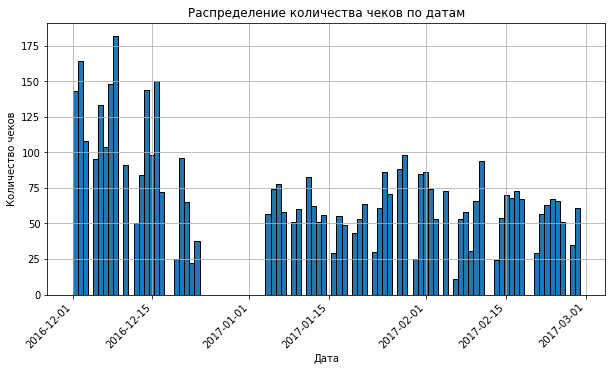

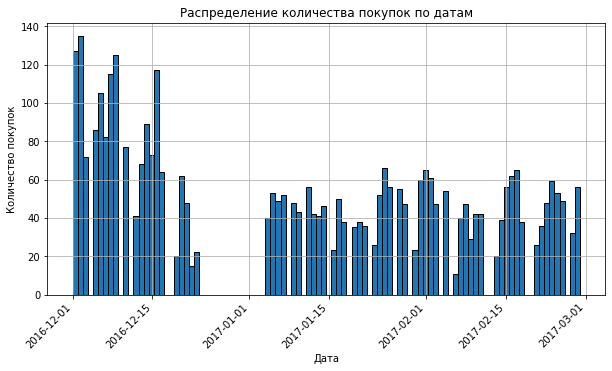

In [32]:
# Выведем графики
histogram('date', 'датам', 'Дата', 'чеков', 'покупок')

На графике виден провал за несколько дней до нового года, так как покупательская активность перемещается в продуктовый сегмент, электронику и бытовую технику и первые дни нового года, что скорее всего связано с новогодними выходными 1, 2 января и ежегодной плановой инвентаризацией 3 января. Как правило, инвентаризация проходит во всём ритейле 2, 3 января. 

Количество чеков выше чем количество покупок, вероятно это связано с возвратами и нулевыми чеками с подарками. 

Видим, что самые высокие продажи в декабре, как правило в ритейле на этот месяц приходится самая высокая покупательская активность. В строительных магазинах она может быть направлена на ёлки, игрушки, мишуру и мелкую элекротехнику (шуруповёрты, дрели, лобзики и т.д.).

In [33]:
# Посмотрим на товарооборот по неделям
turnover_by_week = (
    df
        .groupby('week')
        .agg({'quantity': 'sum', 'revenue': 'sum'})
        .sort_values(by='revenue', ascending=False)
)

turnover_by_week['revenue_percentage'] = turnover_by_week['revenue'] / turnover_by_week['revenue'].sum() * 100
turnover_by_week.head(10).round(2)

,quantity,revenue,revenue_percentage
week,,,
49,101147,316570.57,14.85
50,95739,256579.03,12.04
2,70856,218169.55,10.24
7,65508,173257.98,8.13
8,70577,167897.02,7.88
48,56957,167181.55,7.84
1,58760,152174.93,7.14
3,57630,150448.71,7.06
4,54923,144599.00,6.78


Видим, что пик продаж пришёлся на 49 - 50 недели, а это 5 - 18 декабря 2016 г. и 2-ю неделю с 9 по 15 января 2017 года, что вполне закономерно. После новогодних каникул, люди вернулись к ремонту и покупке строительных материалов. 

In [34]:
# Посмотрим на товарооборот по месяцам
turnover_by_month = (
    df
        .groupby('month')
        .agg({'quantity': 'sum', 'revenue': 'sum'})
        .sort_values(by='revenue', ascending=False)
)

turnover_by_month['revenue_percentage'] = turnover_by_month['revenue'] / turnover_by_month['revenue'].sum() * 100
turnover_by_month.head(10).round(2)


,quantity,revenue,revenue_percentage
month,,,
12,290407,841849.72,39.50
1,255837,698085.45,32.75
2,230009,591426.20,27.75


Декабрь лидирует с долей 39.50 % в общей выручке, что подверждает наш предыдущий вывод, анти-лидер февраль, с долей - 27.75 %. Так же в декабре-январе обычно проводится много распродаж с большими скидками, в результате чего значительно растёт трафик и конверсия.

### Исследуем выручку по магазинам

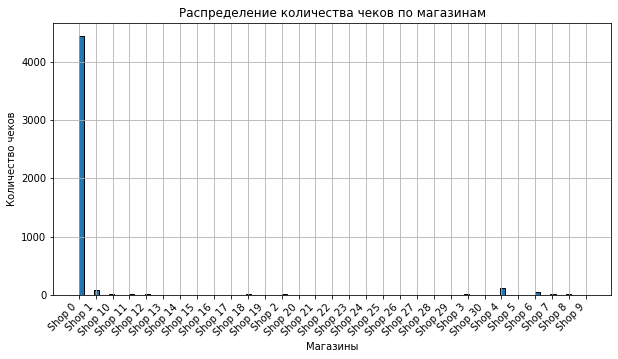

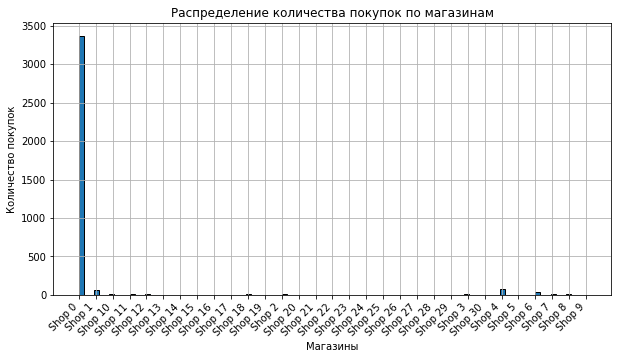

In [35]:
# Распределение количества чеков и покупок по магазинам

histogram('shop_id', 'магазинам', 'Магазины', 'чеков', 'покупок')

Наибольшее количество покупок приходится на магазин `Shop 0`. Вероятно, что это интернет-магазин, уж очень сильно отличается количество чеков и покупок данной локации от всех остальных.

In [36]:
# Посмотрим на товарооборот магазинов
turnover_by_store = (
    df.
        groupby('shop_id')
        .agg({'quantity': 'sum', 'revenue': 'sum'})
        .sort_values(by='revenue', ascending=False)
        .reset_index()
)

turnover_by_store['revenue_percentage'] = turnover_by_store['revenue'] / turnover_by_store['revenue'].sum() * 100
turnover_by_store.round(2)

,shop_id,quantity,revenue,revenue_percentage
0,Shop 0,620633,1717073.36,80.56
1,Shop 3,41657,100164.72,4.70
2,Shop 6,16892,55611.55,2.61
3,Shop 4,17937,50533.04,2.37
4,Shop 1,17894,48030.90,2.25
5,Shop 2,14495,39356.73,1.85
6,Shop 8,5010,16971.03,0.80
7,Shop 14,5406,15893.05,0.75
8,Shop 7,4500,11233.93,0.53
9,Shop 19,6986,10249.60,0.48


In [37]:
# Посмотрим продажи магазина `Shop 23`
df.query('shop_id == "Shop 23"')

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,week,month,product_price,revenue
21882,C540155,72802B,-55,2017-01-05 11:31:00,0.0,Shop 23,0.0,2017-01-05,1,1,4.25,-233.75
36741,539500,72802B,53,2016-12-20 11:02:00,0.0,Shop 23,0.0,2016-12-20,51,12,4.25,225.25


На локацию `Shop 0` приходится 80% всей выручки сети. В локации `Shop 23` выручка отрицательная, не понятно с чем это связано.
Все остальные магазины показывают очень слабые продажи для предновогоднего периода, возможно, что это не магазины вовсе а какие-то товарные группы в отдельно взятом магазине. В любом случае топ-локации `Shop 0`, `Shop 3`, `Shop 6`, антитоп-локации `Shop 23`, `Shop 29`, `Shop 30`

### Исследуем количество уникальных клиентов

In [38]:
# Выведем группировку по номеру клиента и номеру чека
(
    df
        .groupby(['customer_id', 'purchase_id'], as_index=False)
        .agg({'quantity': 'sum'})['customer_id']
        .nunique()
)

1745

Количество уникальных клиентов: 1745

In [39]:
# Посмотрим на количество чеков
(
    df
        .groupby('purchase_id', as_index=False)
        .agg({'quantity': 'sum'})['purchase_id']
        .count()
)

4863

Количество чеков: 4872

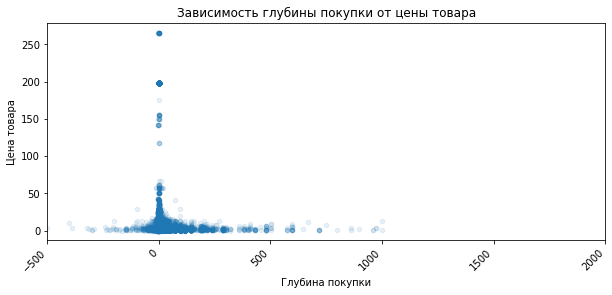

In [40]:
# Посмотрим на зависимость глубины покупки от цены товара
# выведем scatter plot
df.plot(x='quantity', y='product_price', kind='scatter', alpha=0.1, figsize=(10,4))
plt.xlim([-500, 2000])
plt.title('Зависимость глубины покупки от цены товара')
plt.xlabel('Глубина покупки')
plt.ylabel('Цена товара')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()


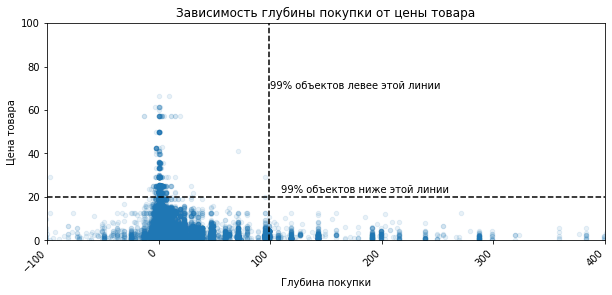

In [41]:
# Зависимость глубины покупки от цены товара (ограничение по осям)

df.plot(x='quantity', y='product_price', kind='scatter', alpha=0.1, figsize=(10,4))
plt.xlim([-100, 400])
plt.ylim([0, 100])
plt.title('Зависимость глубины покупки от цены товара')
plt.xlabel('Глубина покупки')
plt.ylabel('Цена товара')
plt.xticks(rotation=45, horizontalalignment='right')
plt.axhline(np.percentile(df['product_price'], 99), linestyle='--', color='black')
plt.axvline(np.percentile(df['quantity'], 99), linestyle='--', color='black')
plt.text(110,22, '99% объектов ниже этой линии')
plt.text(100,70, '99% объектов левее этой линии')
plt.show()

На товары стоимостью до 20 у.е. приходится 99 % покупок и столько же процентов приходится на один вид товара с количеством до 100 шт. в одном чеке. Думаю, что такая зависимость нормальна для строительного магазина, в котором присутствует много мелкоштучного товара (шурупы, гайки, муфты, петли, мелкий инструмент, семена и т.д.)

### Исследуем количество чеков и покупок по месяцам и неделям

In [42]:
# Выведем группировка по клиенту и чеку
print('Количество чеков по месяцам:')
print(df.groupby('month', as_index=False).agg({'purchase_id': 'nunique'}))
print('------------------------------')
print('Количество покупок по месяцам:')
(
    df
        .groupby(['month', 'purchase_id'], as_index=False)
        .agg({'quantity':'sum'})
        .query('quantity > 0')
        .groupby('month', as_index=False)
        .agg({'purchase_id': 'nunique'})
)

Количество чеков по месяцам:
   month  purchase_id
0      1         1467
1      2         1384
2     12         2012
------------------------------
Количество покупок по месяцам:


,month,purchase_id
0,1,1075
1,2,1077
2,12,1543


In [43]:
# Выведем группировка по клиенту и чеку
print('Количество чеков по неделям:')
print(df.groupby('week', as_index=False).agg({'purchase_id': 'nunique'}))
print('------------------------------')
print('Количество покупок по неделям:')
(
    df
        .groupby(['week', 'purchase_id'], as_index=False)
        .agg({'quantity':'sum'})
        .query('quantity > 0')
        .groupby('week', as_index=False)
        .agg({'purchase_id': 'nunique'})
)

Количество чеков по неделям:
    week  purchase_id
0      1          267
1      2          363
2      3          293
3      4          434
4      5          396
5      6          313
6      7          356
7      8          333
8      9           96
9     48          415
10    49          753
11    50          598
12    51          246
------------------------------
Количество покупок по неделям:


,week,purchase_id
0,1,194
1,2,276
2,3,220
3,4,302
4,5,310
5,6,211
6,7,280
7,8,271
8,9,88
9,48,334


За 3 месяца 4863 чека, из них 3695 чеков с покупками и 41.81 % приходится на декабрь, что в очередной раз подтверждает факт высокой покупательской активности в декабре. Срез по неделям (49-50) подтверждает высокую динамику декабря.

In [44]:
# Посмотрим на товары с нулевым количеством в чеке

zero_сhecks = (
    df
        .groupby(['purchase_id'
                  , 'date'
                  , 'shop_id'
                  , 'loyalty_program'
                  , 'customer_id']
                  , as_index=False)
        .agg({'quantity': 'sum', 'revenue':'sum'})
)

zero_сhecks.columns = (
    ['purchase_id'
     , 'date'
     , 'shop_id'
     , 'loyalty_program'
     , 'customer_id'
     , 'quantity'
     , 'revenue']
)

print('Количество чеков с нулевой суммой:'
      , zero_сhecks.query('revenue == 0')['purchase_id'].count())
print('Количество клиентов с чеками с нулевой суммой:'
      , zero_сhecks.query('revenue == 0')['customer_id'].nunique())

Количество чеков с нулевой суммой: 213
Количество клиентов с чеками с нулевой суммой: 44


In [45]:
# Посмотрим на товары с отрицательным количеством в чеке

negative_checks = (
    df
        .query('quantity > 0')
        .groupby(['product_id'], as_index=False)
        .agg({'quantity': 'sum'})
        .merge(
            df
                .query('quantity < 0')
                .groupby(['product_id'], as_index=False)
                .agg({'quantity': 'sum'})
                    , on='product_id'
                    , how='left'
    )
)

negative_checks.columns = ['product_id', 'sales_quantity', 'negative_quantity']
#negative_checks['negative_quantity'] = negative_checks['negative_quantity'].fillna(0)

negative_checks['sales_quantity_percentage'] = (
    negative_checks['sales_quantity'] / negative_checks['sales_quantity'].sum() * 100).round(2)
negative_checks['negative_quantity_percentage'] = (
    negative_checks['negative_quantity'] / negative_checks['negative_quantity'].sum() * 100).round(2)

returns_by_product = negative_checks.sort_values(by='negative_quantity_percentage', ascending=False)
returns_by_product.head(10)

,product_id,sales_quantity,negative_quantity,sales_quantity_percentage,negative_quantity_percentage
1821,35957,681,-1037.0,0.08,3.63
2397,84997C,1025,-742.0,0.13,2.60
229,20956,394,-724.0,0.05,2.53
10,15036,2119,-650.0,0.26,2.28
2502,85123A,7671,-558.0,0.95,1.95
1882,46000S,86,-402.0,0.01,1.41
602,21621,759,-401.0,0.09,1.40
2218,84614A,1,-391.0,0.00,1.37
659,21696,45,-321.0,0.01,1.12
2109,84050,1765,-313.0,0.22,1.10


Товары с негативными (возвраты) количествами, вероятно это товары, которые были куплены до анализируемого периода. Лучше всего продажи/возвраты по этим товарам проанализировать за весь год, тогда будет чёткое понимание проблемы отрицательных продаж/остатков.

Декабрь - наиболее прибыльный месяц, это обусловлено подготовкой к Новому году, покупкой новогодних товаров, большими распродажами, высокими скидками. Магазин "Shop 0", лидер продаж сети с занимаемой долей в 80 % от товарооборота. Предположу, что это интернет-магазин. Так же есть магазины с очень низкими продажами, которые требуют особого рассмотрения. Желательно осмотреть эти магазины на предмет выявления проблемных точек и провести детальный анализ за более длительный период.  
Для анализа негативных продаж мало данных, нужно взять для анализа бОльший период.

In [46]:
# Продажи и возвраты (в штуках) по магазинам
returns_by_store = pd.DataFrame(
    df
        .query('quantity > 0')
        .groupby('shop_id')
        .agg({'quantity': 'sum'})
        .merge(
                df
                    .query('quantity < 0')
                    .groupby('shop_id')
                    .agg({'quantity': 'sum'})
                        , on='shop_id'
                        ,how='left'
    )
        .reset_index()
)

returns_by_store.columns = ['shop_id', 'sales_quantity', 'returns_quantity']
returns_by_store['returns_quantity'] = returns_by_store['returns_quantity'].fillna(0).apply(lambda x: round(x))

returns_by_store['sales_quantity_percentage'] = round(returns_by_store['sales_quantity'] / returns_by_store['sales_quantity'].sum() * 100, 2)
returns_by_store['returns_quantity_percentage'] = round(returns_by_store['returns_quantity'] / returns_by_store['returns_quantity'].sum() * 100, 2)
returns_by_store['returns_to_sales'] = round(abs(returns_by_store['returns_quantity']) / returns_by_store['sales_quantity'] * 100, 2)

returns_by_store = returns_by_store.sort_values(by='returns_to_sales', ascending=False).reset_index(drop=True)

returns_by_store

,shop_id,sales_quantity,returns_quantity,sales_quantity_percentage,returns_quantity_percentage,returns_to_sales
0,Shop 23,53,-55,0.01,0.18,103.77
1,Shop 21,356,-58,0.04,0.19,16.29
2,Shop 20,364,-49,0.05,0.16,13.46
3,Shop 6,18126,-1234,2.25,4.04,6.81
4,Shop 0,648486,-27853,80.38,91.25,4.30
5,Shop 4,18579,-642,2.30,2.10,3.46
6,Shop 19,7229,-243,0.90,0.80,3.36
7,Shop 11,1366,-36,0.17,0.12,2.64
8,Shop 10,3345,-63,0.41,0.21,1.88
9,Shop 14,5455,-49,0.68,0.16,0.90


### Исследуем распределение покупателей из разных категорий (программа лояльности) в локациях


In [47]:
# Посмотрим на количество уникальных клиентов совершивших покупки
customers_unique = (
    zero_сhecks
        .query('quantity > 0')
        .groupby('loyalty_program', as_index=False)
        .agg({'customer_id': 'nunique'})
)

customers_unique['customers_percentage'] = customers_unique['customer_id'] / customers_unique['customer_id'].sum() * 100
customers_unique.round()

,loyalty_program,customer_id,customers_percentage
0,0.0,1107,66.0
1,1.0,559,34.0


Cреди клиентов совершивших покупки,  34 % являются участниками программы лояльности.

In [48]:
# Посмотрим на суммарную выручку за исключением отрицательных и нулевых чеков
total_revenue = (
    zero_сhecks
        .query('quantity > 0')
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'sum', 'revenue': 'sum'})
)

total_revenue['quantity_percentage'] = total_revenue['quantity'] / total_revenue['quantity'].sum() * 100
total_revenue['revenue_percentage'] = total_revenue['revenue'] / total_revenue['revenue'].sum() * 100
total_revenue.round()

,loyalty_program,quantity,revenue,quantity_percentage,revenue_percentage
0,0.0,598693,1687082.0,74.0,75.0
1,1.0,208084,556645.0,26.0,25.0


Однако, клиенты не участвующие в программе лояльности приносят большую сумму, в относительном выражении - 75 % против 25 %.

In [49]:
# Посмотрим на средний чек (выручка и глубина) за исключением возвратов и чеков с нулевым количеством
average_check = (
    zero_сhecks
        .query('quantity > 0')
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'mean', 'revenue': 'mean'})
        .round()
)

average_check

,loyalty_program,quantity,revenue
0,0.0,232.0,654.0
1,1.0,186.0,499.0


Средний чек и глубина чека выше у неучастников программы 

In [50]:
# Посмотрим на среднее количество позиций в чеке за исключением возвратов и чеков с нулевым количеством

(
    df
        .query('quantity > 0')
        .groupby(['purchase_id', 'loyalty_program', ], as_index=False)
        .agg({'quantity': 'count'})
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'mean'})
        .round()
)

,loyalty_program,quantity
0,0.0,20.0
1,1.0,16.0


Средннее количество позиций в чеке, так же выше у неучастников программы

In [51]:
# Посмотрим на медианный чек (выручка и глубина) за исключением возвратов и чеков с нулевым количеством
median_check = (
    zero_сhecks
        .query('quantity > 0')
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'median', 'revenue': 'median'})
        .round()
)

median_check

,loyalty_program,quantity,revenue
0,0.0,115,346.0
1,1.0,96,296.0


In [52]:
# Посмотрим на медианное количество позиций в чеке за исключением возвратов и чеков с нулевым количеством
(
    df
        .query('quantity > 0')
        .groupby(['purchase_id', 'loyalty_program', ], as_index=False)
        .agg({'quantity': 'count'})
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'median'})
        .round()
)

,loyalty_program,quantity
0,0.0,12
1,1.0,12


Медианные цифры отличаются от средних в меньшую сторону. Так как есть чеки с большим (1000 шт.) количеством товаров, то и средний чек выше. Основная же масса чеков с меньшим количеством, но тут медианные цифры глубины и выручки выше у тех, кто не участвует в программе лояльности. Медианное количество позиций одинаково у участников и неучастников программы лояльности, то есть у неучастников программы больше чеков с большим количеством позиций. Поэтому выходит, что среднее количество позиций у них выше а медианное ниже.

In [53]:
# Посмотрим на крупных покупателей неучаствующих в программе лояльности
customers_b2b = (
    zero_сhecks
        .query('shop_id == "Shop 0" and loyalty_program != 1 and customer_id != 0')
        .groupby(['customer_id'])
        .agg({'quantity': 'max', 'revenue': 'sum'})
        .sort_values(by='revenue', ascending=False)
        .reset_index() 
)

customers_b2b.head(15)

,customer_id,quantity,revenue
0,20740.0,2871,33967.175
1,19977.0,2463,27224.095
2,21708.0,2390,22868.570
3,19373.0,2816,21777.955
4,18768.0,1014,21548.690
5,20990.0,699,18321.425
6,21448.0,1938,18170.760
7,19477.0,2382,17252.805
8,21889.0,1056,14550.085
9,19456.0,1106,12768.810


In [54]:
# Посмотрим на клиентов с нулевыми чеками

(
    zero_сhecks
        .query('revenue == 0')
        .groupby('loyalty_program', as_index=False)
        .agg({'customer_id': 'nunique'})
)

,loyalty_program,customer_id
0,0.0,32
1,1.0,12


Непонятно что в этих чеках, возможно это подарки покупателям. Всего таких чеков 44, при этом у клиентов неучастников программы лояльности их больше.

In [55]:
# Распределение участников программы лояльности по магазинам
(
    zero_сhecks
        .pivot_table(
            index='shop_id'
            , columns='loyalty_program'
            , values='purchase_id'
            , aggfunc='count')
)


loyalty_program,0.0,1.0
shop_id,,
Shop 0,3108.0,1333.0
Shop 1,90.0,NaN
Shop 10,15.0,NaN
Shop 11,10.0,NaN
Shop 12,21.0,NaN
Shop 13,4.0,NaN
Shop 14,5.0,NaN
Shop 15,2.0,NaN
Shop 16,4.0,NaN


Из 31 магазина всего в 4х совершают покупки участники программы лояльности. При этом почти все участники за исключением единичных случаев покупают в магазине "Shop 0". Возможно, все акции и скидки по программе проходят только в одном магазине. Поэтому имеет смысл проанализировать программу лояльности отдельно по магазину "Shop 0".

In [56]:
# Посмотрим средние значения для участников и неучастников программы лояльности по магазину "Shop 0"
# Возьмём средний чек (выручка и глубина чека) за исключением возвратов и чеков с нулевым количеством
loyality_avg_shop0 = (
    zero_сhecks
    .query('quantity > 0 & shop_id == "Shop 0"')
    .groupby('loyalty_program', as_index=False)
    .agg({'quantity': 'mean', 'revenue': 'mean'})
    .round()
)

loyality_avg_shop0


,loyalty_program,quantity,revenue
0,0.0,198.0,563.0
1,1.0,181.0,491.0


In [57]:
# Посмотрим среднее количество позиций в чеке за исключением возвратов и чеков с нулевым количеством
(
    df
        .query('quantity > 0 & shop_id == "Shop 0"')
        .groupby(['purchase_id', 'loyalty_program'], as_index=False)
        .agg({'quantity': 'count'})
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'mean'})
        .round(2)
)

,loyalty_program,quantity
0,0.0,20.03
1,1.0,15.55


По среднему чеку лидируют неучастники программы лояльности. Разница в среднем чеке составляет 15 %, при средней глубине чека 9 %, количество позиций в чеке различается на 29 %. Здесь разница в цифрах между участниками и не-участниками программы меньше.

In [58]:
# Посмотрим медианный чек (выручка и глубина) за исключением возвратов и чеков с нулевым количеством

loyality_median_shop0 = (
    zero_сhecks
        .query('quantity > 0 & shop_id == "Shop 0"')
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'median', 'revenue': 'median'})
        .round()
)

loyality_median_shop0

,loyalty_program,quantity,revenue
0,0.0,110,325.0
1,1.0,96,295.0


In [59]:
# Посмотрим медианное количество позиций в чеке за исключением возвратов и чеков с нулевым количеством
(
    df
        .query('quantity > 0 & shop_id == "Shop 0"')
        .groupby(['purchase_id', 'loyalty_program'], as_index=False)
        .agg({'quantity': 'count'})
        .groupby('loyalty_program', as_index=False)
        .agg({'quantity': 'median'})
        .round()
)

,loyalty_program,quantity
0,0.0,12
1,1.0,12


Медианные цифры примерно совпадают с тем, что получили по всем магазинам.



Вывод

В программе лояльности бОльшую сумму приносят клиенты, которые не участвуют в программе. При том, что 66 % покупателей не являются участниками программы, они приносят 75 % выручки. Неучастники также лидируют и по показателям среднего чека и глубины, и медианных значений.  
Из 31 магазина в 4-ёх совершаются покупки участниками программы лояльности. При этом наибольшая доля покупок совершается в магазине "Shop 0". В данном магазине показатели среднего и медианного чека и глубины выше у неучастников программы.

## Проверка гипотез


**Нулевая гипотеза:** Cтатическая значимость не значительная, различий в средних значениях покупки, глубины чека и частоты покупок нет.

**Альтернативная гипотеза:**  Cтатическая значимость значительная, есть различия в средних значениях.

Порог статической значимости 0.05.

Считаем только по тем клиентам, у которых есть покупки, не берем в расчет возвраты и нулевые чеки, так как нужно понять работает или нет программа лояльности, стимулирует ли она клиентов покупать больше.

In [60]:
def hypothesis(argument, name, name2):
    """ Функция проверяет гипотезу по выручке и глубине чека
    """
    
    df_0 = pd.Series(zero_сhecks.query('quantity > 0 & loyalty_program == 0')[argument])
    df_1 = pd.Series(zero_сhecks.query('quantity > 0 & loyalty_program == 1')[argument])
    
    print('Средн{} для неучастников программы лояльности:'.format(name), df_0.mean())
    print('Средн{} для участников программы лояльности:'.format(name), df_1.mean())
    
    alpha = 0.05
    results_revenue = st.ttest_ind(df_0, df_1, equal_var=False)
    
    print()
    print('P-value:{}'.format(results_revenue.pvalue))
    
    if results_revenue.pvalue < alpha:
        print('Разница средн{} между участниками и неучастниками программы лояльности статистически значима'.format(name2))
    else:
        print('Разница средн{} между участниками и неучастниками программы лояльности статистически не значима'.format(name2))
    
    print(
    'Разница средн{} между участниками и неучастниками программы лояльности:'.format(name2), 
    '{0:.3f}'.format(df_0.mean() / df_1.mean() - 1)
    )

In [61]:
# Считаем статистическое различие в средней выручке
hypothesis('revenue', 'яя выручка', 'ей выручки')

Средняя выручка для неучастников программы лояльности: 654.1611903838697
Средняя выручка для участников программы лояльности: 498.7855689964158

P-value:0.00011352726280864128
Разница средней выручки между участниками и неучастниками программы лояльности статистически значима
Разница средней выручки между участниками и неучастниками программы лояльности: 0.312


Разница в средней выручке между участниками и неучастниками программы лояльности составляет 31%. У неучастников программы средняя выручка выше, различие является существенным.

In [62]:
# Считаем статистическое различие в среднем количестве позиций в чеке
avg_number_of_positions_0 = pd.Series(
    df
        .query('quantity > 0 & loyalty_program == 0')
        .groupby('purchase_id' , as_index=False)
        .agg({'quantity': 'count'})
        .round() ['quantity']
)

avg_number_of_positions_1 = pd.Series(
    df
        .query('quantity > 0 & loyalty_program == 1')
        .groupby('purchase_id', as_index=False)
        .agg({'quantity': 'count'})
        .round() ['quantity']
)

print('Среднее количество позиций для неучастников программы лояльности:', avg_number_of_positions_0.mean())
print('Среднее количество позиций для участников программы лояльности:', avg_number_of_positions_1.mean())
    
alpha = 0.05
results_revenue = st.ttest_ind(avg_number_of_positions_0, avg_number_of_positions_1, equal_var=False)
    
print('\nP-value:{}'.format(results_revenue.pvalue))
    
if results_revenue.pvalue < alpha:
    print('Разница среднего количества позиций между участниками и неучастниками программы лояльности статистически значима')
else:
    print('Разница среднего количества позиций между участниками и неучастниками программы лояльности статистически не значима')
    
print(
    'Разница среднего количества позиций между участниками и неучастниками программы лояльности:', 
    '{0:.3f}'.format(avg_number_of_positions_0.mean() / avg_number_of_positions_1.mean() - 1)
)

Среднее количество позиций для неучастников программы лояльности: 20.3408297789841
Среднее количество позиций для участников программы лояльности: 15.565412186379929

P-value:1.0806616670990756e-09
Разница среднего количества позиций между участниками и неучастниками программы лояльности статистически значима
Разница среднего количества позиций между участниками и неучастниками программы лояльности: 0.307


Разница в среднем количестве позиций в чеке между участниками и неучастниками программы лояльности составляет 31 %. У неучастников программы количество позиций больше, различие является существенным.  
Нулевая гипотеза о том, что нет статистической разницы в средних показателях не подтвердилась.

### Гипотеза о различии средних значений покупки, глубины чека и частоты покупок между теми кто участвует в программе лояльности, и теми кто не участвует в программе для магазина "Shop 0"

**Нулевая гипотеза:** Cтатическая значимость не значительная, различий в средних значениях покупки, глубины чека и частоты покупок нет.  

**Альтернативная гипотеза:** Cтатическая значимость значительная, есть различия в средних значениях.  

Порог статической значимости 0.05.  

Считаем только по тем клиентам, у которых есть покупки, не берем в расчет возвраты и нулевые чеки, так как нужно понять работает или нет программа лояльности, стимулирует ли она клиентов покупать больше.

In [63]:
def hypothesis_shop_0(argument, name, name2):
    """ Функция проверяет гипотезы для магазина "Shop 0"
    """

    data_0 = pd.Series(zero_сhecks.query('quantity > 0 & loyalty_program == 0 & shop_id == "Shop 0"')[argument])
    data_1 = pd.Series(zero_сhecks.query('quantity > 0 & loyalty_program == 1 & shop_id == "Shop 0"')[argument])
    
    print('Средн{} для неучастников программы лояльности:'.format(name), data_0.mean())
    print('Средн{} для участников программы лояльности:'.format(name), data_1.mean())
    
    alpha = 0.05
    results_revenue = st.ttest_ind(data_0, data_1, equal_var=False)
    
    print()
    print('P-value:{}'.format(results_revenue.pvalue))
    
    if results_revenue.pvalue < alpha:
        print('Разница средн{} между участниками и неучастниками программы лояльности статистически значима'.format(name2))
    else:
        print('Разница средн{} между участниками и неучастниками программы лояльности статистически не значима'.format(name2))
    
    print(
    'Разница средн{} между участниками и неучастниками программы лояльности:'.format(name2), 
    '{0:.3f}'.format(data_0.mean() / data_1.mean() - 1)
    )

In [64]:
# Считаем статистическое различие в средней выручке
hypothesis_shop_0('revenue', 'яя выручка', 'ей выручки')

Средняя выручка для неучастников программы лояльности: 562.8642740150509
Средняя выручка для участников программы лояльности: 490.7585855855856

P-value:0.04031761038742815
Разница средней выручки между участниками и неучастниками программы лояльности статистически значима
Разница средней выручки между участниками и неучастниками программы лояльности: 0.147


Разница в средней выручке между участниками и неучастниками программы лояльности составляет 14.7 %. У неучастников программы средняя выручка выше, но при этом различие является не существенным и статистически незначимым.

In [65]:
# Cчитаем статистическое различие в средней глубине чека
hypothesis_shop_0('quantity', 'яя глубина чека', 'ей глубины чека')

Средняя глубина чека для неучастников программы лояльности: 198.1544931385569
Средняя глубина чека для участников программы лояльности: 180.95045045045046

P-value:0.1414560737242962
Разница средней глубины чека между участниками и неучастниками программы лояльности статистически не значима
Разница средней глубины чека между участниками и неучастниками программы лояльности: 0.095


Разница в средней глубине чека между участниками и неучастниками программы лояльности составляет 9.5 %. У неучастников программы средняя глубина чека выше, но при этом различие является не существенным и статистически незначимым.

In [66]:
# считаем статистическое различие в среднем количестве позиций в чеке
avg_number_of_positions_0_shop_0 = pd.Series(
    df    
       .query('quantity > 0 & loyalty_program == 0 & shop_id == "Shop 0"')
       .groupby('purchase_id' , as_index=False)
       .agg({'quantity': 'count'})
       .round() ['quantity']
)

avg_number_of_positions_1_shop_0  = pd.Series(
    df
       .query('quantity > 0 & loyalty_program == 1 & shop_id == "Shop 0"')
       .groupby('purchase_id', as_index=False)
       .agg({'quantity': 'count'})
       .round() ['quantity']
)

print('Среднее количество позиций для неучастников программы лояльности:', avg_number_of_positions_0_shop_0.mean())
print('Среднее количество позиций для участников программы лояльности:', avg_number_of_positions_1_shop_0.mean())
    
alpha = 0.05
results_revenue = st.ttest_ind(avg_number_of_positions_0_shop_0, avg_number_of_positions_1_shop_0, equal_var=False)

print()    
print('P-value:{}'.format(results_revenue.pvalue))
    
if results_revenue.pvalue < alpha:
    print('Разница среднего количества позиций между участниками и неучастниками программы лояльности статистически значима')
else:
    print('Разница среднего количества позиций между участниками и неучастниками программы лояльности статистически не значима')
    
print(
    'Разница среднего количества позиций между участниками и неучастниками программы лояльности:', 
    '{0:.3f}'.format(avg_number_of_positions_0_shop_0.mean() / avg_number_of_positions_1_shop_0.mean() - 1)
)

Среднее количество позиций для неучастников программы лояльности: 20.03010181496237
Среднее количество позиций для участников программы лояльности: 15.54954954954955

P-value:1.0214590782563386e-07
Разница среднего количества позиций между участниками и неучастниками программы лояльности статистически значима
Разница среднего количества позиций между участниками и неучастниками программы лояльности: 0.288


Разница в среднем количестве позиций в чеке между участниками и неучастниками программы лояльности составляет 28.8 %. У неучастников программы количество позиций больше, различие является существенным.

По итогам проверки нулевая гипотеза о том, что нет статистической разницы в средних показателях для магазина "Shop 0" подтвердилась для выручки и глубины чека, но не подтвердилась для среднего количества товаров в чеке.

# Выводы

Самый эффективный магазин сети по всем показателям - "Shop 0" (по-видимому, интернет-магазин). В этом магазине за исследованный период (с 01.12.2016 по 28.02.2017) было совершено 620633 покупок на сумму более 1.7 млн. у.е. Из других магазинов по количеству покупок выделяются магазины "Shop 3" (41657), "Shop 4" (17937).

Наиболее прбыльный месяц - декабрь, на который приходится 41,81 % всех покупок за исследуемый период

Программа лояльности. Основные показатели:

- Cреди клиентов совершивших покупки, 34 % являются участниками программы лояльности.
- Клиенты не участвующие в программе лояльности приносят больший доход - 75 % против 25 %.
- Средний чек (на 31 %) и глубина чека (на 25 %) выше у неучастников программы.
- Средннее количество позиций (на 25 %) в чеке, так же выше у неучастников программы
- Из 31 магазина всего в 4х совершают покупки участники программы лояльности, при этом почти все участники за исключением единичных случаев покупают в магазине "Shop 0"
- По среднему чеку в "Shop 0" лидируют неучастники программы лояльности, разница в среднем чеке составляет 15 %, при средней глубине чека 9 %, количество позиций в чеке различается на 29 %

Проверка гипотез:
- Разница в средней выручке между участниками и неучастниками программы лояльности всей сети составляет 31%. У неучастников программы средняя выручка выше, различие является существенным.
- У неучастников программы количество позиций больше, различие является существенным. Нулевая гипотеза о том, что нет статистической разницы в средних показателях не подтвердилась.
- Разница в средней выручке между участниками и неучастниками программы лояльности в магазине "Shop 0" составляет 14.7 %. У неучастников программы средняя выручка выше, но при этом различие является не существенным и статистически незначимым.
- Разница в средней глубине чека между участниками и неучастниками программы лояльности в магазине "Shop 0" составляет 9.5 %. У неучастников программы средняя глубина чека выше, но при этом различие является не существенным и статистически незначимым.


На основании вышеизложенного предположу, что программа лояльности не стимулирует покупателей приобретать больше товаров. Возможно, программа дает небольшую скидку на товары (3-5%), которая не является существенной в принятии решения о дополнительной покупке.  За 3 месяца 34% клиентов, совершивших покупки, были участниками программы лояльности, при этом они принесли всего 25% от выручки. 

### Рекомендации

Ввиду того, что не располагаю точной информацией о том как работает программа лояльности, предложу следующее:

- Бесплатно выдавать карты участника программы всем желающим.
- Ввести накопительную систему бонусов с кэшбеком в размере 5-10% от суммы покупки. Бонусы можно копить или оплачивать часть покупки, например 50 % - 70 % от суммы чека.
- Первоначальная скидка для всех участников программы 3-5%, далее скидка увеличивается по мере накопления бонусов после достижения определенного порога. 
- Для участников программы проводятся отдельные акции со стартом распродаж на 1-2 дня раньше, чем для неучастников.

## Дашборд и презентация
- Оформление дашборда: <https://public.tableau.com/app/profile/igor.r8366/viz/Dash_retail/Dashboard?publish=yes>
- Оформление презентации: <https://disk.yandex.ru/d/qbLbdUY8VLm97w>